In [148]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

from sklearn.preprocessing import normalize as norm

In [166]:
FILE_PATH = "../Dati/run_chall_ortho_batch_aaAscii_0000.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show()


baselines = np.array(file["tree"]["base"].array()[1:-1]) 
charges = np.array(file["tree"]["charge"].array()[1:-1])
amp = np.array(file["tree"]["amp"].array()[1:-1])
lead_edge = np.array(file["tree"]["letime"].array()[1:-1])
t_edge = np.array(file["tree"]["tetime"].array()[1:-1])
channel= np.array(file["tree"]["ch"].array()[1:-1])
waveform = np.array(file["tree"]["pshape"].array()[1:-1])
flag    = np.array(file["tree"]["Flag"].array()[1:-1])



name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
Flag                 | int32_t[2]               | AsDtype("('>i4', (2,))")
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [167]:
print(waveform[0][7])

[-0.000628 -0.000153 -0.000731 ... -0.047299 -0.052765 -0.064867]


In [128]:
print(flag)

[[ 5  7]
 [ 7 14]
 [ 5 13]
 [ 2  3]
 [ 5  7]
 [10 15]
 [ 2 11]
 [ 2  7]
 [ 6  9]
 [11 13]
 [ 8 14]
 [ 3  7]
 [ 2  9]
 [ 4 10]
 [ 2 11]
 [ 3  7]
 [ 4  6]
 [11 13]
 [ 5  7]
 [ 8 11]
 [11 14]
 [ 6 11]
 [ 4  9]
 [ 2  6]
 [ 8 12]
 [ 9 12]
 [13 14]
 [ 7  9]
 [ 7 15]
 [ 9 13]
 [ 5  7]
 [ 8 11]
 [ 2 12]
 [ 5  7]
 [ 5  8]
 [ 2 11]
 [ 8 14]
 [ 8 15]
 [ 2 11]
 [ 3  7]
 [ 4 13]
 [ 8 11]
 [12 14]
 [ 2 12]
 [11 13]
 [ 7 12]
 [12 14]
 [ 8 11]
 [ 2 14]
 [11 12]
 [ 6  9]
 [ 2  7]
 [ 2  9]
 [ 7  9]
 [ 8 15]
 [ 6 10]
 [ 6  9]
 [ 9 13]
 [ 3 15]
 [11 15]
 [ 2  6]
 [ 7 13]
 [ 3 15]
 [ 2  5]
 [ 8  9]
 [11 15]
 [ 4  8]
 [ 3  9]
 [ 3  8]
 [ 4  8]
 [ 9 15]
 [11 13]
 [11 14]
 [ 8  9]
 [ 3  4]
 [11 14]
 [11 14]
 [10 15]
 [ 2 11]
 [ 2 11]
 [ 8 13]
 [ 6 15]
 [ 8 12]
 [ 4  9]
 [ 7  9]
 [ 4  6]
 [ 9 11]
 [ 2 13]
 [ 2  6]
 [ 5  7]
 [ 2  9]
 [11 13]
 [10 15]
 [ 8  9]
 [14 15]
 [11 15]
 [10 15]
 [ 2  5]
 [ 2  7]
 [ 4 15]
 [ 2 10]
 [ 5 15]
 [ 5  8]
 [ 3  5]
 [ 5  9]
 [ 3 15]
 [ 2 11]
 [ 2  6]
 [ 4 12]
 [ 5  8]
 [ 3  7]
 

In [91]:

N_ch= len(charges[0])
N_ev=len(charges)
print(N_ev, N_ch)

146 16


In [73]:
print(N_ch)

12


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

(8, 2)


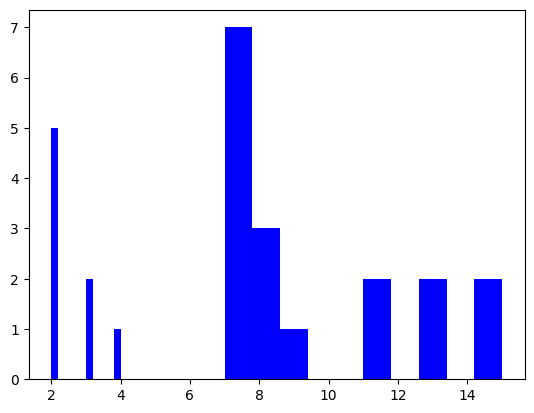

In [126]:
#posso controllare come un canale è accoppiato agli altri
ch=5
msk=np.where(flag[:,0]== ch)[0]
plt.hist(flag[msk, 1],color = "blue")
msk=np.where(flag[:,1]== ch)[0]
plt.hist(flag[msk, 0],color="blue")

print(flag[msk, :].shape)

#

ad ogni event è associata una flag, ora devo selezionare tutti gli event con una stessa flag

In [171]:
def timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh):
    wf_1_len = len(paired_wf_1)
    new_wf_1 = np.array(paired_wf_1).reshape([np.array(paired_wf_1).shape[0], 1, np.array(paired_wf_1).shape[1]])

    for evt in range(new_wf_1.shape[0]):
        for ch in range(new_wf_1.shape[1]):
            bsl_1 = new_wf_1[evt, ch, 0:32].mean()
            new_wf_1[evt, ch, :] = np.convolve(new_wf_1[evt, ch], [1/n_mean] * n_mean, mode = "same") - bsl_1

    new_wf_1 = -norm(-new_wf_1.reshape(-1, 1024), norm = "max", axis = 1, copy = True, return_norm = False)
    threshold = thresh

    ledges1 = np.zeros(new_wf_1.shape[0])

    for evt in range(new_wf_1.shape[0]):
        try:
            ledge= np.where(np.diff(np.sign(new_wf_1[evt] - threshold)))[0][0]
            coef = np.polyfit(new_wf_1[evt][ledge-shiftL:ledge+shiftR],np.arange(ledge-shiftL, ledge+shiftR),1)
            ledges1[evt] = np.poly1d(coef)(threshold) 
        except IndexError:
            continue

    return ledges1*sampling

In [172]:
#data una coppia e un dataset la funzione ritorna l'offset relativo alla misura di timing
def offset_and_resolution_estimation( couple, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    idx=np.where((flag[:,0]==couple[0] ) & (flag[:,1]==couple[1]))[0]
    if(len(idx)>0):
        paired_wf_1=waveform[idx][:,couple[0]]
        paired_wf_2=waveform[idx][:,couple[1]]
        timeres=timing_measurement(paired_wf_1, sampling, shiftR, shiftL, n_mean, thresh)-timing_measurement(paired_wf_2, sampling, shiftR, shiftL, n_mean, thresh)
        return(np.mean(timeres), np.std(timeres), timeres)
    else:
        return(0,0,0)


In [188]:
offset_matrix=np.zeros((N_ch, N_ch))
def offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh):
    for i in range(N_ch):
        for j in range(N_ch):
            tmp=offset_and_resolution_estimation([i,j], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)[0]
            print(i, j, tmp)
            offset_matrix[i][j]=tmp
    return(offset_matrix)



In [175]:
sampling=0.312
shiftR=2
shiftL=0
n_mean=8
thresh=-0.1
print(offset_and_resolution_estimation([5,7], flag, waveform, sampling, shiftR, shiftL, n_mean, thresh))

(0.22652390455647517, 0.5874155666194243, array([-0.01449266,  0.92048975,  0.38100097,  0.70052709,  0.41284988,
        0.22068286, -1.03539055]))


In [176]:
idx = np.array([[1, 3], [1,2,3,4]])
idx2 = [4,6,9,10]

print(idx[idx2])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [189]:
offset_matrix=offset_matrix_filling(N_ch, flag, waveform, sampling, shiftR, shiftL, n_mean, thresh)
print(offset_matrix)

0 0 0
0 1 0
0 2 0
0 3 0
0 4 0
0 5 0
0 6 0
0 7 0
0 8 0
0 9 0
0 10 0
0 11 0
0 12 0
0 13 0
0 14 0
0 15 0
1 0 0
1 1 0
1 2 0
1 3 0
1 4 0
1 5 0
1 6 0
1 7 0
1 8 0
1 9 0
1 10 0
1 11 0
1 12 0
1 13 0
1 14 0
1 15 0
2 0 0
2 1 0
2 2 0
2 3 -2.2060196547204285
2 4 0
2 5 -7.19980176179647
2 6 -2.997206350299342
2 7 -6.250131439080281
2 8 -3.7127343610681223
2 9 -5.198459385316968
2 10 -6.163695677515236
2 11 -7.109202008158909
2 12 -2.168730744888171
2 13 -13.387551046457075
2 14 -2.9743409428920202
2 15 0
3 0 0
3 1 0
3 2 0
3 3 0
3 4 1.0210340959389441
3 5 -0.7199375644408086
3 6 0
3 7 -2.2477755290921686
3 8 -1.4200920773975743
3 9 -3.337947278937566
3 10 0
3 11 -4.995324802226321
3 12 2.863519543351501
3 13 -5.169414073691314e-06
3 14 -1.7962982427411749
3 15 -1.0920388701239405
4 0 0
4 1 0
4 2 0
4 3 0
4 4 0
4 5 -0.7645718869110425
4 6 0.3682512601713803
4 7 0
4 8 -0.6403337973815013
4 9 -1.0022564218840593
4 10 -2.8375474735155137
4 11 0
4 12 3.4902901894901692
4 13 0.4413706078324182
4 14 0
4 15 -